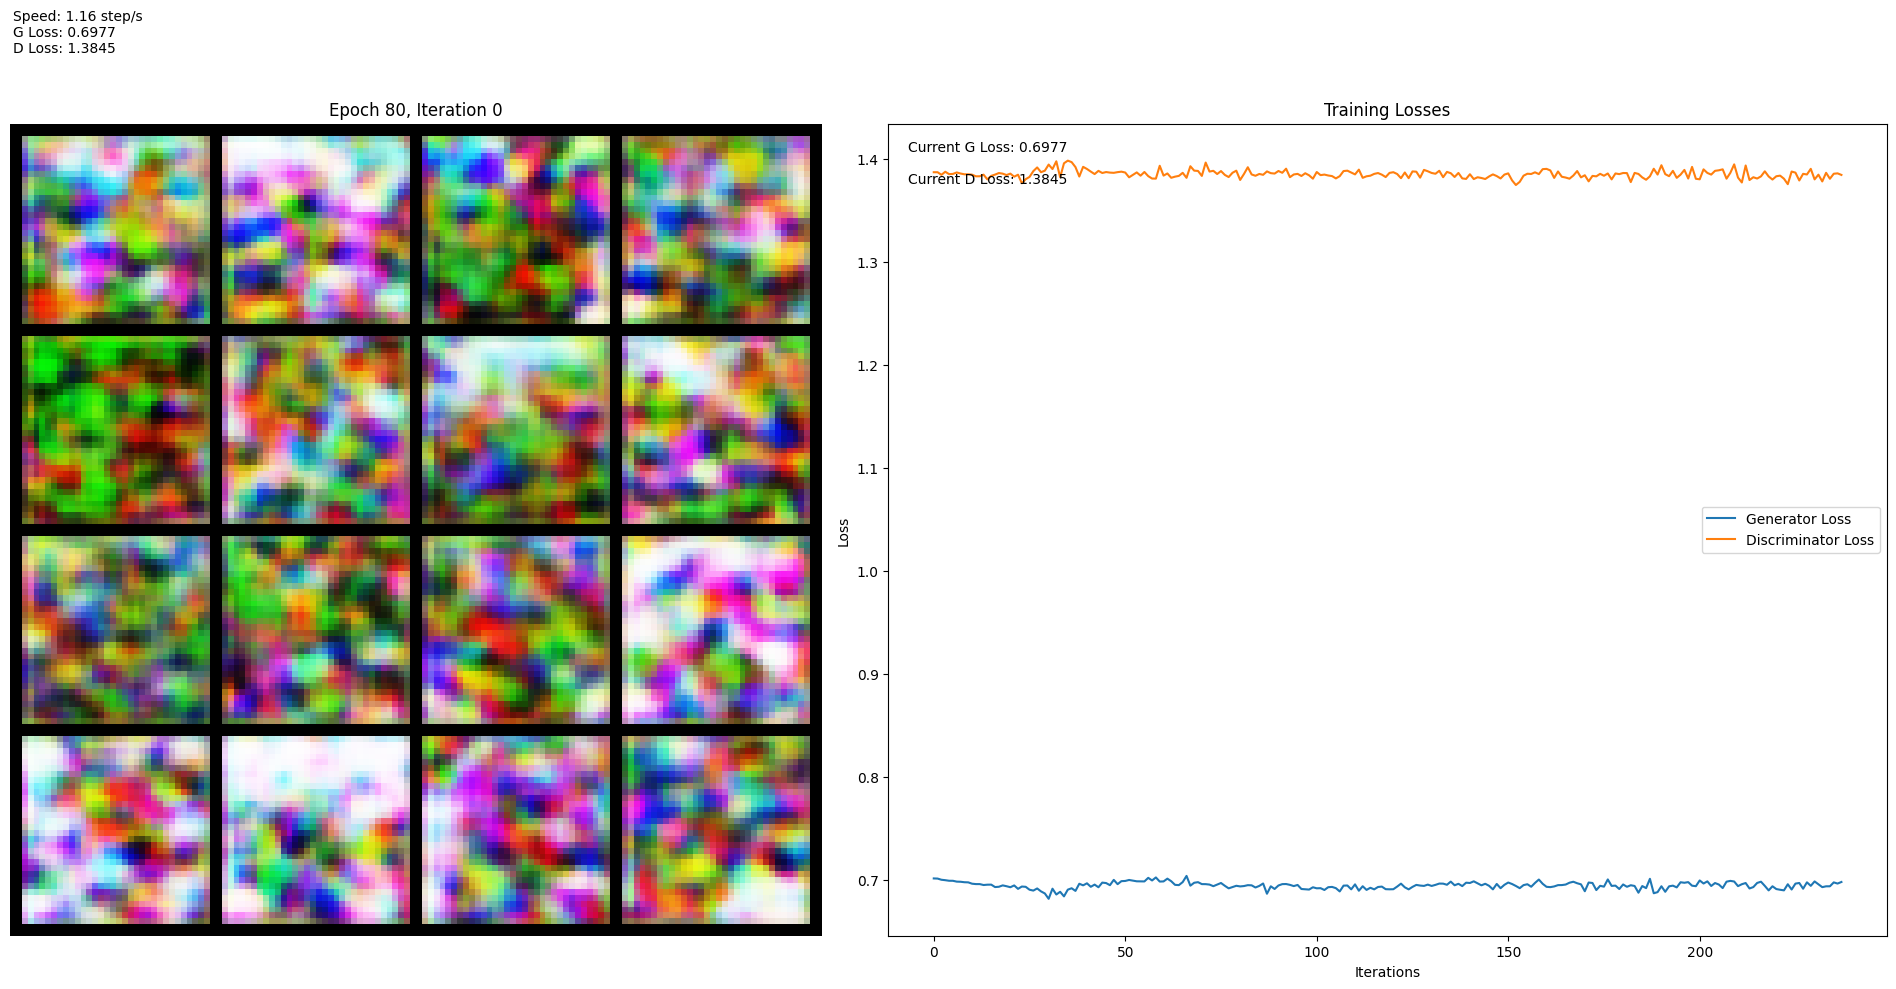

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from accelerate import Accelerator
import time
import math

from pyrodigy.optimizer_wrapper import OptimizerWrapper

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
latent_dim = 100
channels = 3
batch_size = 16
epochs = 200
lr = 0.0001
beta1 = 0.5

# Define image size (you can change this value)
img_size = 32

# Calculate number of layers based on image size
num_layers = int(math.log2(img_size)) - 2

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.channels = channels

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size, channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2**4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity.view(-1)
    

# Hyperparameters
###img_size = 64
#latent_dim = 100
#channels = 3

# Initialize models
generator = Generator(img_size, latent_dim, channels)
discriminator = Discriminator(img_size, channels)

# Test forward pass
test_noise = torch.randn(64, latent_dim)
test_img = generator(test_noise)
print(f"Generated image shape: {test_img.shape}")

test_validity = discriminator(test_img)
print(f"Discriminator output shape: {test_validity.shape}")

# Set up data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='D:\\Diffusion\\Training\\_datasets\\dreamweaver\\dreamweaver_cont\\blubb', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Initialize models and optimizers
generator = Generator(img_size, latent_dim, channels)
discriminator = Discriminator(img_size, channels)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(beta1, 0.999))#OptimizerWrapper(generator.parameters(),"adabound","high_memory", lr = 0.001) #
d_optimizer = optim.Adam(discriminator.parameters(),   lr=0.0001, betas=(beta1, 0.999))#ptimizerWrapper(discriminator.parameters(),"adabound","high_memory", lr = 0.001) #

# Initialize Accelerator
accelerator = Accelerator(mixed_precision="no")
generator, discriminator, g_optimizer, d_optimizer, dataloader = accelerator.prepare(
    generator, discriminator, g_optimizer, d_optimizer, dataloader
)

# Loss function
criterion = nn.BCELoss()

# Training loop
g_losses = []
d_losses = []

# Set up the plot
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.show()

# Initialize variables for speed calculation
start_time = time.time()
steps = 0
speed = 0



for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)

        # Train discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(batch_size, device=accelerator.device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        z = torch.randn(batch_size, latent_dim, device=accelerator.device)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size, device=accelerator.device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        accelerator.backward(d_loss)
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, device=accelerator.device)
        fake_images = generator(z)
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)
        
        accelerator.backward(g_loss)
        g_optimizer.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Calculate speed
        steps += 1
        elapsed_time = time.time() - start_time
        speed = steps / elapsed_time

        # Visualize results every 50 iterations
        if i % 50 == 0:
            # Generate and visualize fake images
            with torch.no_grad():
                fake_images = generator(torch.randn(16, latent_dim, device=accelerator.device))
                fake_images = accelerator.gather(fake_images)
                fake_images = fake_images.cpu()
                grid = make_grid(fake_images[:16], nrow=4, normalize=True)
                
                ax1.clear()
                ax1.imshow(grid.permute(1, 2, 0))
                ax1.axis('off')
                ax1.set_title(f"Epoch {epoch+1}, Iteration {i}")

                # Add speed and loss values to the image
                info_text = f"Speed: {speed:.2f} step/s\n"
                info_text += f"G Loss: {g_loss.item():.4f}\n"
                info_text += f"D Loss: {d_loss.item():.4f}"
                ax1.text(0, -20, info_text, fontsize=10, verticalalignment='top')

            # Plot loss curves
            ax2.clear()
            ax2.plot(g_losses, label='Generator Loss')
            ax2.plot(d_losses, label='Discriminator Loss')
            ax2.set_xlabel('Iterations')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.set_title('Training Losses')

            # Add current loss values to the plot
            ax2.text(0.02, 0.98, f"Current G Loss: {g_loss.item():.4f}", transform=ax2.transAxes, verticalalignment='top')
            ax2.text(0.02, 0.94, f"Current D Loss: {d_loss.item():.4f}", transform=ax2.transAxes, verticalalignment='top')

            plt.tight_layout()
            
            # Update the plot
            fig.canvas.draw()
            fig.canvas.flush_events()
            
            # Display the plot (for Jupyter notebook)
            clear_output(wait=True)
            display(fig)

plt.ioff()
plt.show()